In [1]:
import os
import math
import pickle
import numpy as np
import tensorflow as tf
import skimage as ski
import skimage.io
import matplotlib.pyplot as plt

from tensorflow.contrib.layers import xavier_initializer_conv2d as xavier_conv2d
from tensorflow.contrib.layers import xavier_initializer as xavier

tf.reset_default_graph()

<h1> Utility methods </h1>

In [2]:
def evaluate(session, name, imgs, labels):
    print("\nRunning evaluation: ", name)
    batch_size = config['batch_size']
    num_examples = imgs.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    cnt_correct = 0
    loss_avg = 0
    
    print("Examples %d\tBatches %d " % (num_examples, num_batches))
    print("")

    for i in range(num_batches):
        batch_x = imgs[i*batch_size:(i+1)*batch_size, ...]
        batch_y = labels[i*batch_size:(i+1)*batch_size, ...]
        
        learning_rate = float((num_batches - i)/(num_batches))
        if (learning_rate <= 0.05):
            learning_rate = 0.001

        data_dict = {x: batch_x, y: batch_y, weight_decay: config["weight_decay"],
                     is_training: False, lr: learning_rate}
        loss_val, predicted = session.run([loss, logits], feed_dict=data_dict)

        yp = np.argmax(predicted, 1)
        yt = batch_y
        cnt_correct += (yp == yt).sum()
        loss_avg += loss_val
        
    acc = (cnt_correct / num_examples * 100)
    loss_avg /= num_batches
    print(name + " accuracy = %.4f" % acc)
    print(name + " avg loss = %.4f\n" % loss_avg)
    return loss_avg, acc


def shuffle_data(data_x, data_y):
    indices = np.arange(data_x.shape[0])
    np.random.shuffle(indices)
    shuffled_data_x = np.ascontiguousarray(data_x[indices])
    shuffled_data_y = np.ascontiguousarray(data_y[indices])
    return shuffled_data_x, shuffled_data_y


def batch_norm(inputs, is_training, dims, decay=0.999, epsilon=1e-3):

        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

        def if_true():
            batch_mean, batch_var = tf.nn.moments(inputs, dims)
            train_mean = tf.assign(pop_mean,
                                   pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,
                                  pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                                                 batch_mean, batch_var, beta, scale, epsilon)

        def if_false():
            return tf.nn.batch_normalization(inputs,
                                             pop_mean, pop_var, beta, scale, epsilon)

        result = tf.cond(is_training, if_true, if_false)
        return result


def conv_2d(tensor, filters, biases, is_training=None, dims=None, strides=1, activation=tf.nn.relu):
    h1 = tf.nn.conv2d(tensor, filters, strides=[1, strides, strides, 1], padding='SAME')
    h1 = tf.nn.bias_add(h1, biases)
    return activation(batch_norm(h1, is_training, dims))


def max_pool_2d(tensor, k_size=2, stride=2, padding='SAME'):
    return tf.nn.max_pool(tensor, ksize=[1, k_size, k_size, 1], strides=[1, stride, stride, 1], padding=padding)


# FC layer
def dense(tensor, filters, biases, is_training=None, dims=None, activation=None):
    tensor = tf.reshape(tensor, [-1, filters.get_shape().as_list()[0]])
    res = tf.matmul(tensor, filters) + biases
    if activation:
        print ("Using activation on FC: ", activation)
        return activation(batch_norm(res, is_training, dims))
    print("Not using activation on FC")
    return res


def multiclass_hinge_loss(logits, label, n_classes, delta=10):
    label_oh = tf.one_hot(label, depth=n_classes, dtype=tf.float32)
    mask = 1-label_oh
    
    correct_logits = tf.diag(tf.reduce_sum(label_oh * logits, 1))
    correct_logits_mat = tf.matmul(correct_logits, tf.ones_like(logits))
    
    errors = tf.nn.relu(logits - correct_logits_mat + delta)
    return errors * mask

<h1> Plot methods </h1>

In [3]:
def plot_training_progress(data, save_dir=None):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)
  if save_dir is not None:
    save_path = os.path.join(save_dir, 'training_plot.pdf')
    print('Plotting in: ', save_path)
    plt.savefig(save_path)
    plt.close()
  else:
    plt.show()
    
    

def draw_conv_filters(epoch, step, weights, save_dir):
  k, k, C, num_filters = weights.shape

  w = weights.copy().swapaxes(0, 3).swapaxes(1,2)
  w = w.reshape(num_filters, C, k, k)
  w -= w.min()
  w /= w.max()

  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border

  for i in range(1):
    img = np.zeros([height, width])
    for j in range(num_filters):
      r = int(j / cols) * (k + border)
      c = int(j % cols) * (k + border)
      img[r:r+k,c:c+k] = w[j,i]
    filename = 'epoch_%02d_step_%06d_input_%03d.png' % (epoch, step, i)
    ski.io.imsave(os.path.join(save_dir, filename), img)
    
    
def show_image(img, mean, std):
  img = img.copy()
  img *= std
  img += mean
  img = img.astype(np.uint8)
  ski.io.imshow(img)
  ski.io.show()

<h1> Preprocessing data </h1>

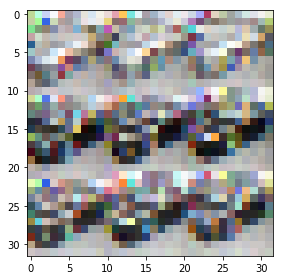

Input shape: (45000, 32, 32, 3)
Classes: 
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [18]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict


def get_label_names(blob):
    label_dict = unpickle(blob)['label_names']
    return np.array(label_dict)


DATA_DIR = 'CIFAR_data/'

img_height, img_width, num_channels = 32, 32, 3
train_x = np.ndarray((0, img_height * img_width * num_channels), dtype=np.float32)
train_y = []
for i in range(1, 6):
  subset = unpickle(os.path.join(DATA_DIR, 'data_batch_%d' % i))
  train_x = np.vstack((train_x, subset['data']))
  train_y += subset['labels']

train_x = train_x.reshape((-1, img_height, img_width, num_channels))
train_y = np.array(train_y, dtype=np.int32)

subset = unpickle(os.path.join(DATA_DIR, 'test_batch'))
test_x = subset['data'].reshape((-1, img_height, img_width, num_channels)).astype(np.float32)
test_y = np.array(subset['labels'], dtype=np.int32)

valid_size = 5000
train_x, train_y = shuffle_data(train_x, train_y)
valid_x = train_x[:valid_size, ...]
valid_y = train_y[:valid_size, ...]
train_x = train_x[valid_size:, ...]
train_y = train_y[valid_size:, ...]
data_mean = train_x.mean()
data_std = train_x.std()

train_x = (train_x - data_mean) / data_std
valid_x = (valid_x - data_mean) / data_std
test_x = (test_x - data_mean) / data_std
show_image(train_x[0], data_mean, data_std)
print("Input shape:", train_x.shape)
class_names = get_label_names(os.path.join(DATA_DIR, 'batches.meta'))
print("Classes: \n", class_names)

#### <h1> CONFIG FILE </h1>

In [5]:
config = {
    "max_epochs" : 40,
    "batch_size" : 50,
    "weight_decay" : 1e-4,
    "SAVE_DIR" : "output_cifar_conv/"
}

OUTPUT_SHAPE = 10

In [6]:
def worst_samples(session, imgs, labels):
  batch_size = config['batch_size']
  num_examples = imgs.shape[0]
  num_batches = num_examples // batch_size

  worst_samples = []
  for i in range(num_batches):
    batch_x = imgs[i*batch_size:(i+1)*batch_size, ...]
    batch_y = labels[i*batch_size:(i+1)*batch_size, ...]
    
    data_dict = {x: batch_x, y: batch_y, weight_decay: config["weight_decay"], is_training: False}
    loss_vals, logits_val = session.run([loss_on_samples, logits] ,feed_dict=data_dict)
    prediction = np.argmax(logits_val, 1)
    loss_pairs = [(i*batch_size+id, loss, p) for id, (loss, p) in enumerate(zip(loss_vals, prediction))]
    worst_samples = sorted(loss_pairs, key=lambda val: -val[1])[:20]
  return worst_samples

<h1> Weights & Biases </h1>

In [7]:
weights = {
    'conv1': tf.get_variable('w_conv1', [5, 5, 3, 16], initializer=xavier_conv2d()),
    'conv2': tf.get_variable('w_conv2', [5, 5, 16, 32], initializer=xavier_conv2d()),

    'fc3': tf.get_variable('w_fc3', [8 * 8 * 32, 256], initializer=xavier()),
    'fc4': tf.get_variable('w_fc4', [256, 128], initializer=xavier()),
    'fc5': tf.get_variable('w_fc5', [128, OUTPUT_SHAPE], initializer=xavier())
}

biases = {
    'conv1': tf.Variable(tf.zeros([16]), name='b_conv1'),
    'conv2': tf.Variable(tf.zeros([32]), name='b_conv2'),
    'fc3': tf.Variable(tf.zeros([256]), name='b_fc3'),
    'fc4': tf.Variable(tf.zeros([128]), name='b_fc4'),
    'fc5': tf.Variable(tf.zeros([OUTPUT_SHAPE]), name='b_fc5')
}

<h1> LAYERS </h1>

In [8]:
weight_decay = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)


def get_logits(entry, weights, biases):
    #################### 1ST LAYER ####################
    # h1 is [batch_size, 32, 32, 16]
    net = conv_2d(entry, weights["conv1"], biases["conv1"], is_training=is_training, dims=[0, 1, 2])
    print("H1:", net.get_shape())

    # max pool convolved layer [batch_size, 16, 16, 16]
    net = max_pool_2d(net, k_size=3, stride=2)
    print("H1 pooled:", net.get_shape())

    #################### 2ND LAYER ####################
    # h2 is [batch_size, 16, 16, 32]
    net = conv_2d(net, weights["conv2"], biases["conv2"], is_training=is_training, dims=[0, 1, 2])
    print("H2:", net.get_shape())

    # max pool convolved layer [batch_size, 8, 8, 32]
    net = max_pool_2d(net, k_size=3, stride=2)
    print("H2 pooled:", net.get_shape())

    #################### FC LAYER ####################

    net = dense(net, weights['fc3'], biases['fc3'], is_training=is_training, dims=[0, 1], activation=tf.nn.relu)
    print("FC1:", net.get_shape())

    #################### FC LAYER ####################

    net = dense(net, weights['fc4'],  biases['fc4'], is_training=is_training, dims=[0, 1], activation=tf.nn.relu)
    print("FC2:", net.get_shape())

    #################### FC LAYER ####################
    # logits is [batch_size, 10]
    net = dense(net, weights['fc5'],  biases['fc5'], is_training=is_training, dims=[0, 1], activation=None)
    print("Logits:", net.get_shape())
    return net

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.int32, shape=[None, ])
logits = get_logits(x, weights, biases)

H1: (?, 32, 32, 16)
H1 pooled: (?, 16, 16, 16)
H2: (?, 16, 16, 32)
H2 pooled: (?, 8, 8, 32)
Using activation on FC:  <function relu at 0x7f5775d29840>
FC1: (?, 256)
Using activation on FC:  <function relu at 0x7f5775d29840>
FC2: (?, 128)
Not using activation on FC
Logits: (?, 10)


<h1> Loss & Train step </h1>

In [9]:
regularizers = 0
for w in weights.values():
    regularizers += tf.nn.l2_loss(w)

#loss_on_samples = multiclass_hinge_loss(logits, y, OUTPUT_SHAPE)
loss_on_samples = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(loss_on_samples)
print("Loss:", loss)
    
loss = loss + weight_decay*regularizers

lr = tf.placeholder(tf.float32)
train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

Loss: Tensor("Mean:0", shape=(), dtype=float32)


<h1> MAIN CODE </h1>

epoch 1, step 50/900, batch loss = 1.94, lr = 0.010


/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 100/900, batch loss = 1.97, lr = 0.010
epoch 1, step 150/900, batch loss = 1.79, lr = 0.010
epoch 1, step 200/900, batch loss = 1.91, lr = 0.010
epoch 1, step 250/900, batch loss = 1.83, lr = 0.010
epoch 1, step 300/900, batch loss = 2.05, lr = 0.010
epoch 1, step 350/900, batch loss = 1.60, lr = 0.010
epoch 1, step 400/900, batch loss = 1.77, lr = 0.010
epoch 1, step 450/900, batch loss = 1.54, lr = 0.010
epoch 1, step 500/900, batch loss = 1.47, lr = 0.010
epoch 1, step 550/900, batch loss = 1.60, lr = 0.010
epoch 1, step 600/900, batch loss = 1.48, lr = 0.010
epoch 1, step 650/900, batch loss = 1.57, lr = 0.010
epoch 1, step 700/900, batch loss = 1.49, lr = 0.010
epoch 1, step 750/900, batch loss = 1.50, lr = 0.010
epoch 1, step 800/900, batch loss = 1.67, lr = 0.010
epoch 1, step 850/900, batch loss = 1.75, lr = 0.010
epoch 1, step 900/900, batch loss = 1.68, lr = 0.010

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 46.7622
Train avg loss = 

epoch 8, step 50/900, batch loss = 0.88, lr = 0.008
epoch 8, step 100/900, batch loss = 1.08, lr = 0.008
epoch 8, step 150/900, batch loss = 1.11, lr = 0.008
epoch 8, step 200/900, batch loss = 0.91, lr = 0.008
epoch 8, step 250/900, batch loss = 0.85, lr = 0.008
epoch 8, step 300/900, batch loss = 0.87, lr = 0.008
epoch 8, step 350/900, batch loss = 1.22, lr = 0.008
epoch 8, step 400/900, batch loss = 1.20, lr = 0.008
epoch 8, step 450/900, batch loss = 1.06, lr = 0.008
epoch 8, step 500/900, batch loss = 1.08, lr = 0.008
epoch 8, step 550/900, batch loss = 1.03, lr = 0.008
epoch 8, step 600/900, batch loss = 1.05, lr = 0.008
epoch 8, step 650/900, batch loss = 1.28, lr = 0.008
epoch 8, step 700/900, batch loss = 0.87, lr = 0.008
epoch 8, step 750/900, batch loss = 0.95, lr = 0.008
epoch 8, step 800/900, batch loss = 1.22, lr = 0.008
epoch 8, step 850/900, batch loss = 1.20, lr = 0.008
epoch 8, step 900/900, batch loss = 0.96, lr = 0.008

Running evaluation:  Train
Examples 45000	Batc

Validation accuracy = 62.2200
Validation avg loss = 1.1253

epoch 15, step 50/900, batch loss = 0.76, lr = 0.006
epoch 15, step 100/900, batch loss = 0.72, lr = 0.006
epoch 15, step 150/900, batch loss = 1.06, lr = 0.006
epoch 15, step 200/900, batch loss = 0.94, lr = 0.006
epoch 15, step 250/900, batch loss = 0.79, lr = 0.006
epoch 15, step 300/900, batch loss = 0.86, lr = 0.006
epoch 15, step 350/900, batch loss = 0.77, lr = 0.006
epoch 15, step 400/900, batch loss = 0.69, lr = 0.006
epoch 15, step 450/900, batch loss = 1.01, lr = 0.006
epoch 15, step 500/900, batch loss = 0.63, lr = 0.006
epoch 15, step 550/900, batch loss = 0.81, lr = 0.006
epoch 15, step 600/900, batch loss = 0.79, lr = 0.006
epoch 15, step 650/900, batch loss = 0.84, lr = 0.006
epoch 15, step 700/900, batch loss = 1.12, lr = 0.006
epoch 15, step 750/900, batch loss = 0.74, lr = 0.006
epoch 15, step 800/900, batch loss = 0.77, lr = 0.006
epoch 15, step 850/900, batch loss = 0.73, lr = 0.006
epoch 15, step 900/900,

Train accuracy = 79.1533
Train avg loss = 0.6454


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 62.0200
Validation avg loss = 1.2071

epoch 22, step 50/900, batch loss = 0.58, lr = 0.004
epoch 22, step 100/900, batch loss = 0.55, lr = 0.004
epoch 22, step 150/900, batch loss = 0.74, lr = 0.004
epoch 22, step 200/900, batch loss = 0.46, lr = 0.004
epoch 22, step 250/900, batch loss = 0.59, lr = 0.004
epoch 22, step 300/900, batch loss = 0.34, lr = 0.004
epoch 22, step 350/900, batch loss = 0.45, lr = 0.004
epoch 22, step 400/900, batch loss = 0.56, lr = 0.004
epoch 22, step 450/900, batch loss = 0.48, lr = 0.004
epoch 22, step 500/900, batch loss = 0.51, lr = 0.004
epoch 22, step 550/900, batch loss = 0.70, lr = 0.004
epoch 22, step 600/900, batch loss = 0.38, lr = 0.004
epoch 22, step 650/900, batch loss = 0.70, lr = 0.004
epoch 22, step 700/900, batch loss = 0.56, lr = 0.004
epoch 22, step 750/900, batch loss = 0.47, lr = 0.004
epoch 22, step 800/9

epoch 28, step 850/900, batch loss = 0.42, lr = 0.003
epoch 28, step 900/900, batch loss = 0.81, lr = 0.003

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 87.7444
Train avg loss = 0.4262


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 63.0200
Validation avg loss = 1.2082

epoch 29, step 50/900, batch loss = 0.29, lr = 0.003
epoch 29, step 100/900, batch loss = 0.42, lr = 0.003
epoch 29, step 150/900, batch loss = 0.43, lr = 0.003
epoch 29, step 200/900, batch loss = 0.41, lr = 0.003
epoch 29, step 250/900, batch loss = 0.34, lr = 0.003
epoch 29, step 300/900, batch loss = 0.31, lr = 0.003
epoch 29, step 350/900, batch loss = 0.36, lr = 0.003
epoch 29, step 400/900, batch loss = 0.51, lr = 0.003
epoch 29, step 450/900, batch loss = 0.34, lr = 0.003
epoch 29, step 500/900, batch loss = 0.38, lr = 0.003
epoch 29, step 550/900, batch loss = 0.43, lr = 0.003
epoch 29, step 600/900, batch loss = 0.48, lr = 0.003
epoch 29, step 65

epoch 35, step 700/900, batch loss = 0.27, lr = 0.001
epoch 35, step 750/900, batch loss = 0.25, lr = 0.001
epoch 35, step 800/900, batch loss = 0.27, lr = 0.001
epoch 35, step 850/900, batch loss = 0.29, lr = 0.001
epoch 35, step 900/900, batch loss = 0.29, lr = 0.001

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 93.6533
Train avg loss = 0.2978


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 63.4400
Validation avg loss = 1.2629

epoch 36, step 50/900, batch loss = 0.35, lr = 0.001
epoch 36, step 100/900, batch loss = 0.37, lr = 0.001
epoch 36, step 150/900, batch loss = 0.43, lr = 0.001
epoch 36, step 200/900, batch loss = 0.31, lr = 0.001
epoch 36, step 250/900, batch loss = 0.29, lr = 0.001
epoch 36, step 300/900, batch loss = 0.38, lr = 0.001
epoch 36, step 350/900, batch loss = 0.29, lr = 0.001
epoch 36, step 400/900, batch loss = 0.34, lr = 0.001
epoch 36, step 450/900, batch loss = 0.41, lr = 0.001
epoch 36, step 50

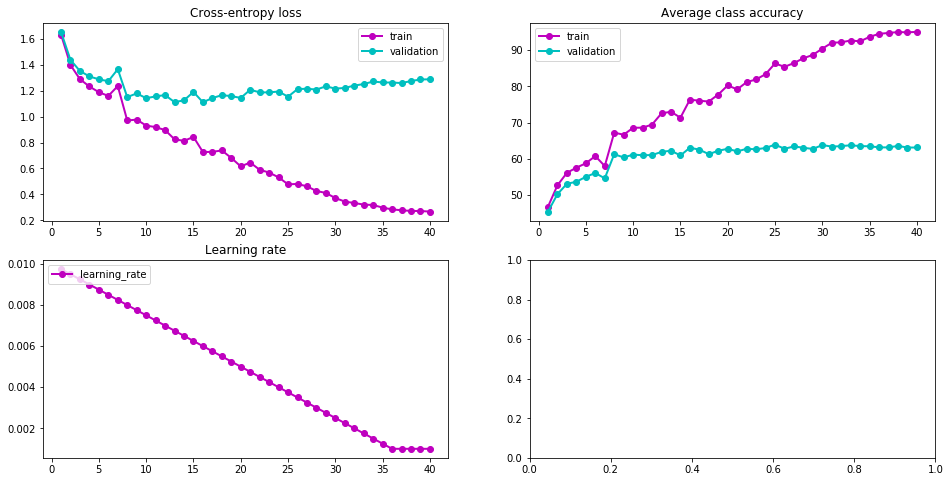


Running evaluation:  Test
Examples 10000	Batches 200 

Test accuracy = 63.7900
Test avg loss = 1.2602



In [10]:
def train(sess, train_x, train_y, valid_x, valid_y, test_x, test_y, plot_data={}):
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    
    sess.run(tf.global_variables_initializer())

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    num_examples = train_x.shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size

    for epoch in range(1, max_epochs + 1):
        learning_rate = float((max_epochs - epoch)/(max_epochs*100))
        if (learning_rate <= 0.001):
            learning_rate = 0.001
        plot_data['lr'] += [learning_rate]

        cnt_correct = 0

        train_x, train_y = shuffle_data(train_x, train_y)

        for i in range(num_batches):
            # store mini-batch to ndarray
            batch_x = train_x[i * batch_size:(i + 1) * batch_size, ...]
            batch_y = train_y[i * batch_size:(i + 1) * batch_size, ...]

            data_dict = {x: batch_x, y: batch_y, weight_decay: config["weight_decay"],
                         is_training: True, lr: learning_rate}
            loss_val, _ = sess.run([loss, train_step], feed_dict=data_dict)

            if (i+1) % 50 == 0:
                print("epoch %d, step %d/%d, batch loss = %.2f, lr = %.3f" %
                      (epoch, i+1, num_batches, loss_val, learning_rate))
                w = sess.run(weights['conv1'])
                draw_conv_filters(epoch, i * batch_size, w, config["SAVE_DIR"])
        # evaluate on validation set after each epoch        
        train_loss, train_acc = evaluate(sess, "Train", train_x, train_y)
        valid_loss, valid_acc = evaluate(sess, "Validation",  valid_x, valid_y)
        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [valid_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [valid_acc]
    plot_training_progress(plot_data, None)

    # TESTING
    evaluate(sess, "Test", test_x, test_y)
    
sess = tf.Session()
train(sess, train_x, train_y, valid_x, valid_y, test_x, test_y)

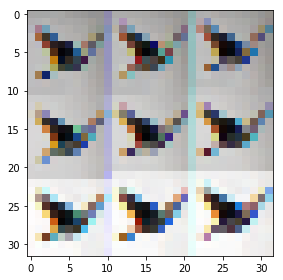

Correct class: bird
Predictions: ['airplane' 'bird' 'cat'] [  9.99411345e-01   5.32452599e-04   3.69367008e-05]


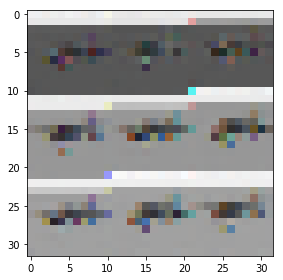

Correct class: airplane
Predictions: ['ship' 'airplane' 'automobile'] [  9.96172130e-01   2.86285602e-03   5.68383606e-04]


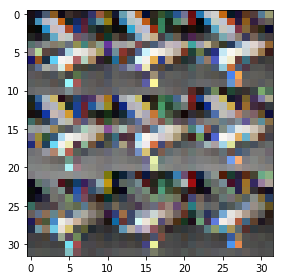

Correct class: automobile
Predictions: ['deer' 'cat' 'dog'] [ 0.88910711  0.05718761  0.04179166]


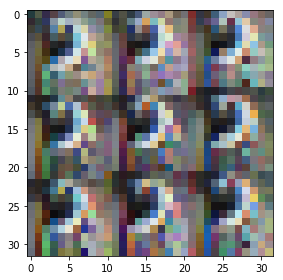

Correct class: cat
Predictions: ['bird' 'dog' 'cat'] [ 0.91119391  0.07724854  0.00573844]


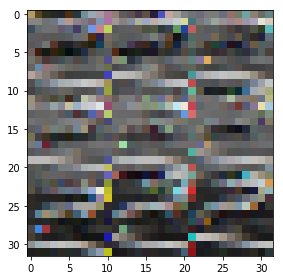

Correct class: airplane
Predictions: ['cat' 'bird' 'automobile'] [ 0.53620833  0.20496339  0.18320118]


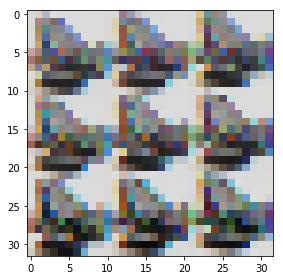

Correct class: frog
Predictions: ['cat' 'truck' 'ship'] [ 0.34260869  0.26574263  0.10252   ]


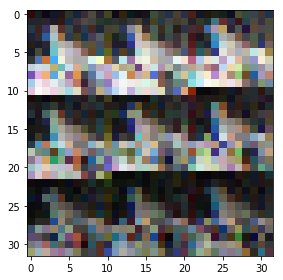

Correct class: bird
Predictions: ['frog' 'deer' 'cat'] [ 0.74902737  0.15031178  0.03837491]


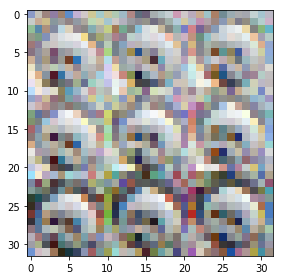

Correct class: dog
Predictions: ['frog' 'automobile' 'cat'] [ 0.63103992  0.13328891  0.13251939]


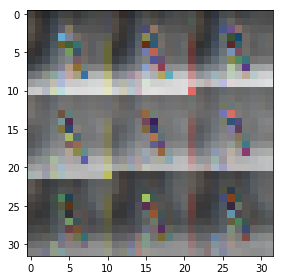

Correct class: bird
Predictions: ['deer' 'bird' 'cat'] [ 0.93519765  0.04819321  0.00805302]


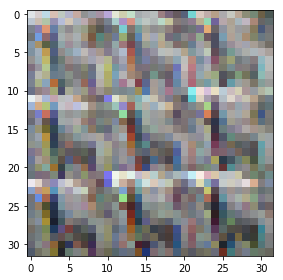

Correct class: horse
Predictions: ['dog' 'deer' 'horse'] [ 0.66901952  0.169615    0.0791095 ]


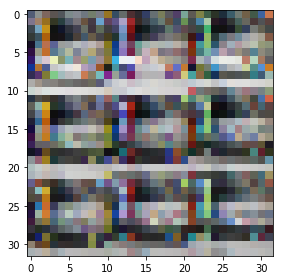

Correct class: automobile
Predictions: ['truck' 'automobile' 'cat'] [ 0.90962547  0.08609179  0.00280437]


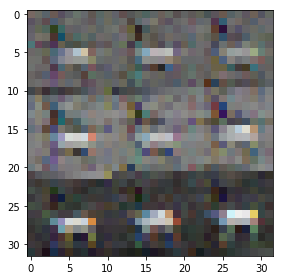

Correct class: deer
Predictions: ['bird' 'horse' 'airplane'] [ 0.39773962  0.29883868  0.15404682]


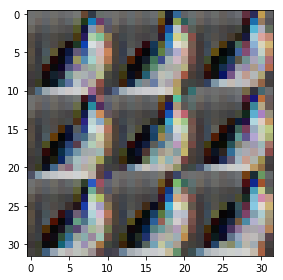

Correct class: bird
Predictions: ['dog' 'cat' 'bird'] [ 0.36550927  0.3551732   0.27536005]


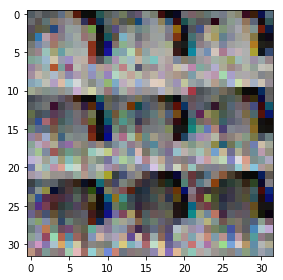

Correct class: cat
Predictions: ['frog' 'cat' 'dog'] [ 0.67622429  0.27925247  0.02541998]


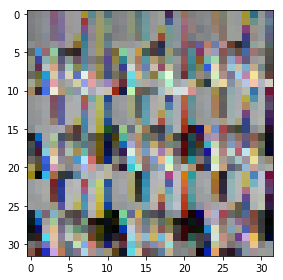

Correct class: cat
Predictions: ['bird' 'cat' 'airplane'] [ 0.33574003  0.28265363  0.17597254]


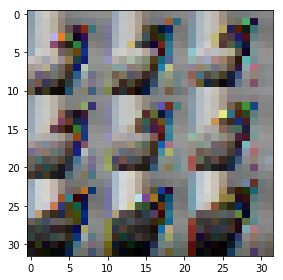

Correct class: bird
Predictions: ['bird' 'dog' 'cat'] [ 0.2920413   0.25971738  0.25452819]


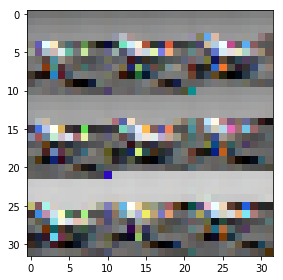

Correct class: airplane
Predictions: ['automobile' 'airplane' 'truck'] [ 0.54545325  0.30196953  0.1030215 ]


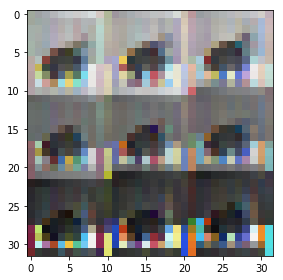

Correct class: cat
Predictions: ['deer' 'cat' 'dog'] [ 0.44929984  0.38434958  0.1163599 ]


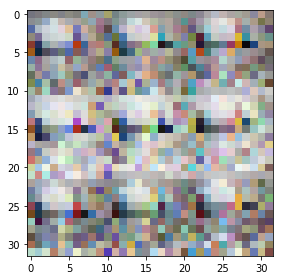

Correct class: bird
Predictions: ['dog' 'bird' 'deer'] [ 0.53120905  0.39621228  0.02616387]


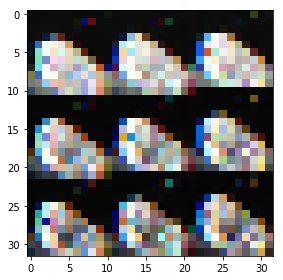

Correct class: dog
Predictions: ['dog' 'frog' 'cat'] [ 0.42819098  0.35171729  0.12098808]


In [11]:
worst = worst_samples(sess, test_x, test_y)

for sample_id, l, predicted in worst:
    show_image(test_x[sample_id], data_mean, data_std)
    probas = sess.run(tf.nn.softmax(logits), feed_dict={x: np.array([test_x[sample_id]]), is_training: False})
    probas = probas[0]
    predictions  = np.argsort(-probas)

    print("Correct class:", class_names[test_y[sample_id]])
    print("Predictions:", class_names[predictions[:3]], probas[predictions[:3]])

In [12]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.int32, shape=[None, ])
logits = get_logits(x, weights, biases)

regularizers = 0
for w in weights.values():
    regularizers += tf.nn.l2_loss(w)

loss_on_samples = multiclass_hinge_loss(logits, y, OUTPUT_SHAPE)
loss = tf.reduce_mean(loss_on_samples)
print("Loss:", loss)
    
loss = loss + weight_decay*regularizers

lr = tf.placeholder(tf.float32)
train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)

H1: (?, 32, 32, 16)
H1 pooled: (?, 16, 16, 16)
H2: (?, 16, 16, 32)
H2 pooled: (?, 8, 8, 32)
Using activation on FC:  <function relu at 0x7f5775d29840>
FC1: (?, 256)
Using activation on FC:  <function relu at 0x7f5775d29840>
FC2: (?, 128)
Not using activation on FC
Logits: (?, 10)
Loss: Tensor("Mean_1:0", shape=(), dtype=float32)


epoch 1, step 50/900, batch loss = 6.84, lr = 0.010


/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


epoch 1, step 100/900, batch loss = 6.95, lr = 0.010
epoch 1, step 150/900, batch loss = 5.46, lr = 0.010
epoch 1, step 200/900, batch loss = 5.25, lr = 0.010
epoch 1, step 250/900, batch loss = 4.62, lr = 0.010
epoch 1, step 300/900, batch loss = 4.25, lr = 0.010
epoch 1, step 350/900, batch loss = 4.84, lr = 0.010
epoch 1, step 400/900, batch loss = 4.36, lr = 0.010
epoch 1, step 450/900, batch loss = 4.82, lr = 0.010
epoch 1, step 500/900, batch loss = 5.09, lr = 0.010
epoch 1, step 550/900, batch loss = 4.20, lr = 0.010
epoch 1, step 600/900, batch loss = 4.82, lr = 0.010
epoch 1, step 650/900, batch loss = 3.78, lr = 0.010
epoch 1, step 700/900, batch loss = 3.96, lr = 0.010
epoch 1, step 750/900, batch loss = 4.42, lr = 0.010
epoch 1, step 800/900, batch loss = 4.20, lr = 0.010
epoch 1, step 850/900, batch loss = 3.11, lr = 0.010
epoch 1, step 900/900, batch loss = 3.58, lr = 0.010

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 42.0044
Train avg loss = 

epoch 8, step 50/900, batch loss = 2.37, lr = 0.008
epoch 8, step 100/900, batch loss = 2.35, lr = 0.008
epoch 8, step 150/900, batch loss = 2.29, lr = 0.008
epoch 8, step 200/900, batch loss = 1.36, lr = 0.008
epoch 8, step 250/900, batch loss = 1.41, lr = 0.008
epoch 8, step 300/900, batch loss = 1.57, lr = 0.008
epoch 8, step 350/900, batch loss = 1.87, lr = 0.008
epoch 8, step 400/900, batch loss = 1.92, lr = 0.008
epoch 8, step 450/900, batch loss = 2.18, lr = 0.008
epoch 8, step 500/900, batch loss = 1.69, lr = 0.008
epoch 8, step 550/900, batch loss = 1.38, lr = 0.008
epoch 8, step 600/900, batch loss = 2.14, lr = 0.008
epoch 8, step 650/900, batch loss = 1.05, lr = 0.008
epoch 8, step 700/900, batch loss = 2.01, lr = 0.008
epoch 8, step 750/900, batch loss = 1.45, lr = 0.008
epoch 8, step 800/900, batch loss = 2.78, lr = 0.008
epoch 8, step 850/900, batch loss = 2.20, lr = 0.008
epoch 8, step 900/900, batch loss = 1.75, lr = 0.008

Running evaluation:  Train
Examples 45000	Batc

Validation accuracy = 61.7200
Validation avg loss = 2.1018

epoch 15, step 50/900, batch loss = 1.24, lr = 0.006
epoch 15, step 100/900, batch loss = 1.00, lr = 0.006
epoch 15, step 150/900, batch loss = 0.98, lr = 0.006
epoch 15, step 200/900, batch loss = 1.62, lr = 0.006
epoch 15, step 250/900, batch loss = 1.10, lr = 0.006
epoch 15, step 300/900, batch loss = 1.01, lr = 0.006
epoch 15, step 350/900, batch loss = 1.10, lr = 0.006
epoch 15, step 400/900, batch loss = 1.35, lr = 0.006
epoch 15, step 450/900, batch loss = 0.93, lr = 0.006
epoch 15, step 500/900, batch loss = 0.79, lr = 0.006
epoch 15, step 550/900, batch loss = 1.44, lr = 0.006
epoch 15, step 600/900, batch loss = 0.61, lr = 0.006
epoch 15, step 650/900, batch loss = 1.22, lr = 0.006
epoch 15, step 700/900, batch loss = 0.93, lr = 0.006
epoch 15, step 750/900, batch loss = 1.15, lr = 0.006
epoch 15, step 800/900, batch loss = 1.42, lr = 0.006
epoch 15, step 850/900, batch loss = 1.75, lr = 0.006
epoch 15, step 900/900,

Train accuracy = 80.1067
Train avg loss = 0.7767


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 63.6400
Validation avg loss = 2.0383

epoch 22, step 50/900, batch loss = 0.62, lr = 0.004
epoch 22, step 100/900, batch loss = 1.06, lr = 0.004
epoch 22, step 150/900, batch loss = 1.09, lr = 0.004
epoch 22, step 200/900, batch loss = 0.74, lr = 0.004
epoch 22, step 250/900, batch loss = 0.82, lr = 0.004
epoch 22, step 300/900, batch loss = 0.95, lr = 0.004
epoch 22, step 350/900, batch loss = 0.98, lr = 0.004
epoch 22, step 400/900, batch loss = 0.87, lr = 0.004
epoch 22, step 450/900, batch loss = 0.51, lr = 0.004
epoch 22, step 500/900, batch loss = 0.65, lr = 0.004
epoch 22, step 550/900, batch loss = 0.55, lr = 0.004
epoch 22, step 600/900, batch loss = 1.02, lr = 0.004
epoch 22, step 650/900, batch loss = 0.61, lr = 0.004
epoch 22, step 700/900, batch loss = 0.74, lr = 0.004
epoch 22, step 750/900, batch loss = 0.83, lr = 0.004
epoch 22, step 800/9

epoch 28, step 850/900, batch loss = 0.40, lr = 0.003
epoch 28, step 900/900, batch loss = 0.35, lr = 0.003

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 88.0000
Train avg loss = 0.4613


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 63.9200
Validation avg loss = 2.0394

epoch 29, step 50/900, batch loss = 0.46, lr = 0.003
epoch 29, step 100/900, batch loss = 0.59, lr = 0.003
epoch 29, step 150/900, batch loss = 0.50, lr = 0.003
epoch 29, step 200/900, batch loss = 0.42, lr = 0.003
epoch 29, step 250/900, batch loss = 0.53, lr = 0.003
epoch 29, step 300/900, batch loss = 0.45, lr = 0.003
epoch 29, step 350/900, batch loss = 0.42, lr = 0.003
epoch 29, step 400/900, batch loss = 0.45, lr = 0.003
epoch 29, step 450/900, batch loss = 0.44, lr = 0.003
epoch 29, step 500/900, batch loss = 0.57, lr = 0.003
epoch 29, step 550/900, batch loss = 0.56, lr = 0.003
epoch 29, step 600/900, batch loss = 0.48, lr = 0.003
epoch 29, step 65

epoch 35, step 700/900, batch loss = 0.27, lr = 0.001
epoch 35, step 750/900, batch loss = 0.27, lr = 0.001
epoch 35, step 800/900, batch loss = 0.69, lr = 0.001
epoch 35, step 850/900, batch loss = 0.49, lr = 0.001
epoch 35, step 900/900, batch loss = 0.20, lr = 0.001

Running evaluation:  Train
Examples 45000	Batches 900 

Train accuracy = 91.7756
Train avg loss = 0.3184


Running evaluation:  Validation
Examples 5000	Batches 100 

Validation accuracy = 63.9000
Validation avg loss = 2.1130

epoch 36, step 50/900, batch loss = 0.42, lr = 0.001
epoch 36, step 100/900, batch loss = 0.31, lr = 0.001
epoch 36, step 150/900, batch loss = 0.35, lr = 0.001
epoch 36, step 200/900, batch loss = 0.33, lr = 0.001
epoch 36, step 250/900, batch loss = 0.28, lr = 0.001
epoch 36, step 300/900, batch loss = 0.34, lr = 0.001
epoch 36, step 350/900, batch loss = 0.20, lr = 0.001
epoch 36, step 400/900, batch loss = 0.29, lr = 0.001
epoch 36, step 450/900, batch loss = 0.40, lr = 0.001
epoch 36, step 50

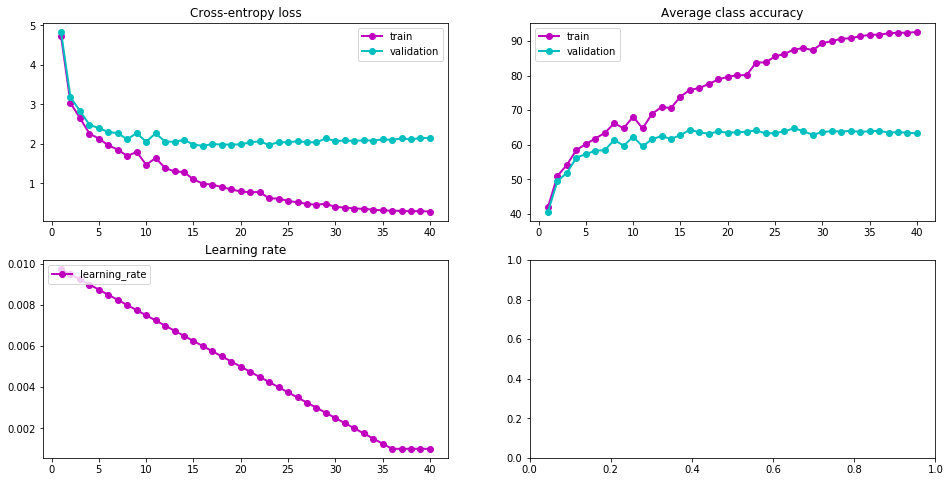


Running evaluation:  Test
Examples 10000	Batches 200 

Test accuracy = 64.1400
Test avg loss = 2.0702



In [13]:
sess2 = tf.Session()
train(sess2, train_x, train_y, valid_x, valid_y, test_x, test_y)